In [2]:
from google.colab import files
import pandas as pd
import numpy as np

uploaded = files.upload()
file_names = list(uploaded.keys())
file_names



Saving Borrower.txt to Borrower.txt
Saving Borrower_Prod.txt to Borrower_Prod.txt
Saving Loan.txt to Loan.txt
Saving Loan_Default_Prediction.ipynb to Loan_Default_Prediction.ipynb


['Borrower.txt',
 'Borrower_Prod.txt',
 'Loan.txt',
 'Loan_Default_Prediction.ipynb']

In [4]:
data_files = [fn for fn in file_names if fn.endswith('.txt')]
dfs = [pd.read_csv(fn, sep="\t") for fn in data_files]
df_ms = pd.concat(dfs, ignore_index=True)
print(df_ms.shape)
df_ms.head()

(200022, 27)


,memberId,residentialState,yearsEmployment,homeOwnership,annualIncome,incomeVerified,dtiRatio,lengthCreditHistory,numTotalCreditLines,numOpenCreditLines,...,loanId,date,purpose,isJointApplication,loanAmount,term,interestRate,monthlyPayment,grade,loanStatus
0,2305095,NM,10+ years,rent,56471.0,1.0,16.80,6.0,11.0,9.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2610493,WA,2-5 years,rent,55038.0,0.0,19.99,22.0,8.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2491679,MS,< 1 year,rent,56610.0,1.0,14.33,5.0,8.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2092798,TX,6-9 years,own,54887.0,1.0,14.80,12.0,14.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2633077,MA,2-5 years,rent,53522.0,1.0,10.14,4.0,21.0,19.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:

def convert_status(x):
    x = str(x).lower()
    if "charged" in x or "default" in x or "late" in x:
        return 1   # default
    else:
        return 0   # non-default

df_ms["loanStatus"] = df_ms["loanStatus"].apply(convert_status).astype(int)


In [6]:
df_ms = df_ms.dropna(subset=["loanStatus"])


In [7]:
TARGET_MS = "loanStatus"
df_ms[TARGET_MS] = df_ms[TARGET_MS].astype(int)


if "memberId" in df_ms.columns:
    df_ms = df_ms.drop(columns=["memberId"])


df_ms = df_ms.replace([np.inf, -np.inf], np.nan)


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

X_ms = df_ms.drop(columns=[TARGET_MS])
y_ms = df_ms[TARGET_MS]

X_train_ms, X_test_ms, y_train_ms, y_test_ms = train_test_split(
    X_ms, y_ms, test_size=0.2, random_state=42, stratify=y_ms
)

num_cols_ms = X_ms.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols_ms = X_ms.select_dtypes(include=['object']).columns.tolist()

numeric_process_ms = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_process_ms = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_ms = ColumnTransformer([
    ('num', numeric_process_ms, num_cols_ms),
    ('cat', categorical_process_ms, cat_cols_ms)
])

In [14]:
!pip install -q xgboost
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from xgboost import XGBClassifier

models = {
    "Logistic Regression": LogisticRegression(max_iter=2000, class_weight='balanced'),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=6, min_samples_leaf=20, min_samples_split=40, random_state=42
    ),
    "Random Forest": RandomForestClassifier(
        n_estimators=200, max_depth=8,
        min_samples_leaf=15, min_samples_split=30,
        class_weight="balanced", random_state=42
    ),
    "Naive Bayes": GaussianNB(),
    "Linear SVM": LinearSVC(class_weight='balanced', max_iter=5000, random_state=42),
    "XGBoost": XGBClassifier(
        n_estimators=400,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.7,
        colsample_bytree=0.6,
        min_child_weight=10,
        gamma=2.0,
        reg_alpha=1.0,
        reg_lambda=5.0,
        eval_metric='auc',
        random_state=42,
        n_jobs=-1,
    )
}


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def evaluate_model(model, name, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"\n🔹 {name} Accuracy: {acc*100:.2f}%")
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    plt.figure(figsize=(5,4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'{name} - Confusion Matrix')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    return {"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1}



==================== Training Logistic Regression (Microsoft) ====================

🔹 Logistic Regression (MS) Accuracy: 81.02%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     38004
           1       0.19      0.86      0.31      2001

    accuracy                           0.81     40005
   macro avg       0.59      0.83      0.60     40005
weighted avg       0.95      0.81      0.86     40005



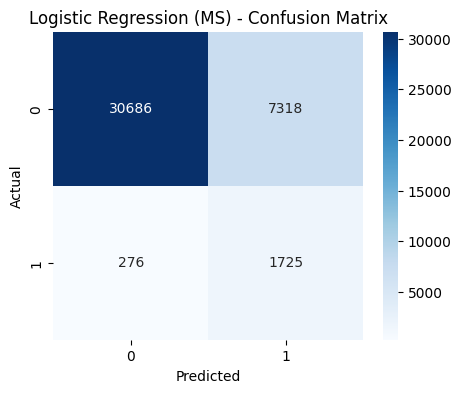


==================== Training Decision Tree (Microsoft) ====================

🔹 Decision Tree (MS) Accuracy: 95.52%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     38004
           1       0.70      0.18      0.29      2001

    accuracy                           0.96     40005
   macro avg       0.83      0.59      0.63     40005
weighted avg       0.95      0.96      0.94     40005



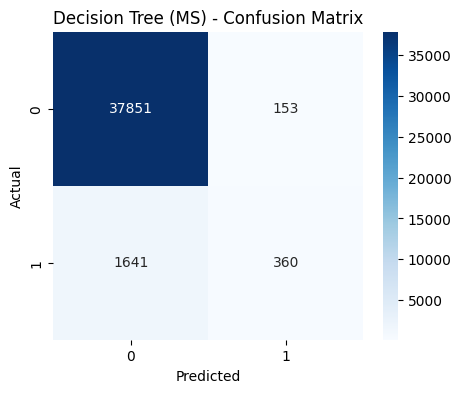


==================== Training Random Forest (Microsoft) ====================

🔹 Random Forest (MS) Accuracy: 55.79%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.70     38004
           1       0.10      1.00      0.18      2001

    accuracy                           0.56     40005
   macro avg       0.55      0.77      0.44     40005
weighted avg       0.95      0.56      0.67     40005



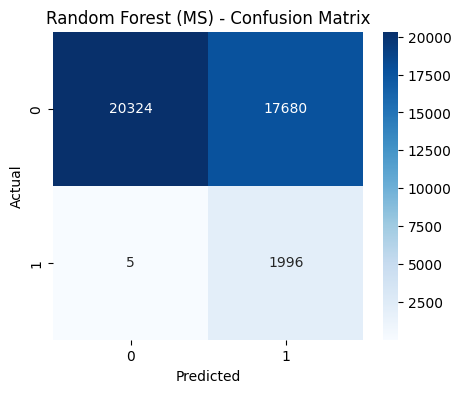


==================== Training Naive Bayes (Microsoft) ====================

🔹 Naive Bayes (MS) Accuracy: 55.16%
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.53      0.69     38004
           1       0.10      1.00      0.18      2001

    accuracy                           0.55     40005
   macro avg       0.55      0.76      0.44     40005
weighted avg       0.95      0.55      0.67     40005



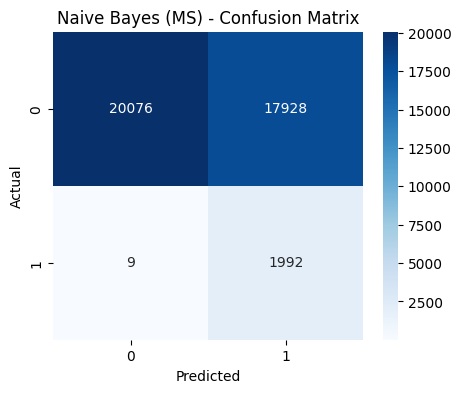


==================== Training Linear SVM (Microsoft) ====================

🔹 Linear SVM (MS) Accuracy: 81.16%
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.81      0.89     38004
           1       0.19      0.87      0.31      2001

    accuracy                           0.81     40005
   macro avg       0.59      0.84      0.60     40005
weighted avg       0.95      0.81      0.86     40005



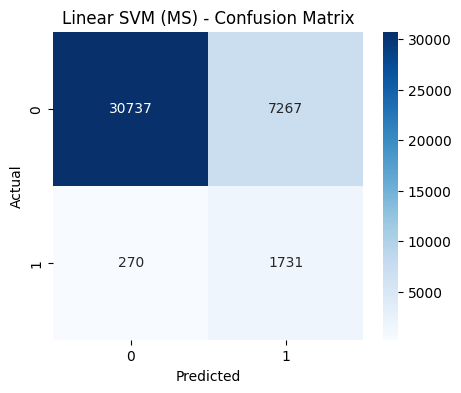


==================== Training XGBoost (Microsoft) ====================

🔹 XGBoost (MS) Accuracy: 95.69%
Classification Report:
              precision    recall  f1-score   support

           0       0.96      1.00      0.98     38004
           1       0.76      0.20      0.32      2001

    accuracy                           0.96     40005
   macro avg       0.86      0.60      0.65     40005
weighted avg       0.95      0.96      0.94     40005



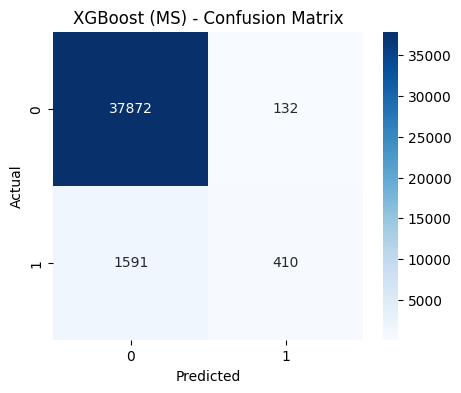

,Model,Accuracy,Precision,Recall,F1,Accuracy %
0,Logistic Regression,0.810174,0.190755,0.862069,0.312387,81.02
1,Decision Tree,0.955156,0.701754,0.179910,0.286396,95.52
2,Random Forest,0.557930,0.101443,0.997501,0.184158,55.79
3,Naive Bayes,0.551631,0.100000,0.995502,0.181744,55.16
4,Linear SVM,0.811599,0.192376,0.865067,0.314756,81.16
5,XGBoost,0.956930,0.756458,0.204898,0.322454,95.69


In [17]:
from sklearn.preprocessing import FunctionTransformer

results_ms = []

for name, clf in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor_ms)
    ])

    # GaussianNB requires dense input, so convert sparse output from preprocessor
    if name == "Naive Bayes":
        pipe.steps.append(('to_dense', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)))

    pipe.steps.append(('clf', clf))

    print(f"\n==================== Training {name} (Microsoft) ====================")
    pipe.fit(X_train_ms, y_train_ms)
    res = evaluate_model(pipe, name + " (MS)", X_test_ms, y_test_ms)
    res["Model"] = name
    results_ms.append(res)

results_ms_df = pd.DataFrame(results_ms)
results_ms_df["Accuracy %"] = (results_ms_df["Accuracy"] * 100).round(2)
results_ms_df